# VAE Model 

In [ ]:
%pip install torch -q

In [ ]:

%pip install scipy scikit-learn matplotlib pandas anndata scanpy -q


In [1]:
# Step 1：import dependencies
from pathlib import Path
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import mmread
from scipy import sparse

print('NumPy version:', np.__version__)


NumPy version: 1.26.4


In [11]:
from scipy import sparse
tfidf_sparse = sparse.load_npz('/Users/christina/Desktop/ResearchBioe/New_preprocessing_method_train01/preprocessed_cutntag_final2.npz')
cell_names = Path('/Users/christina/Desktop/ResearchBioe/New_preprocessing_method_train01/filtered_cells_final2.txt').read_text().splitlines()
peak_names = Path('/Users/christina/Desktop/ResearchBioe/New_preprocessing_method_train01/filtered_peaks_final2.txt').read_text().splitlines()

print('final matrix:', tfidf_sparse.shape)

final matrix: (15000, 307)


In [12]:
# Step 7：define dataset wrapper
class TfidfDataset(Dataset):
    def __init__(self, matrix, log1p=True, zscore=False, l2_norm=True):
        if sparse.issparse(matrix):
            self.matrix = matrix.tocsc().astype(np.float32)
        else:
            self.matrix = sparse.csc_matrix(matrix, dtype=np.float32)
        self.log1p = log1p
        self.zscore = zscore
        self.l2_norm = l2_norm

        if self.zscore:
            mean = np.asarray(self.matrix.mean(axis=1)).ravel().astype(np.float32)
            sq_mean = np.asarray(self.matrix.power(2).mean(axis=1)).ravel().astype(np.float32)
            var = np.clip(sq_mean - mean ** 2, a_min=1e-8, a_max=None)
            self.feature_mean = mean
            self.feature_std = np.sqrt(var)
        else:
            self.feature_mean = None
            self.feature_std = None

    def __len__(self):
        return self.matrix.shape[1]

    def __getitem__(self, idx):
        vec = self.matrix.getcol(idx).toarray().ravel()
        if self.log1p:
            vec = np.log1p(vec)
        if self.zscore:
            vec = (vec - self.feature_mean) / self.feature_std
        if self.l2_norm:
            norm = np.linalg.norm(vec)
            if norm > 0:
                vec = vec / norm
        return torch.from_numpy(vec.astype(np.float32))


In [13]:
# Step 8：load dataset and create DataLoader
dataset_log1p = TfidfDataset(tfidf_sparse, log1p=True, zscore=False, l2_norm=True)
train_fraction = 0.8
num_cells = len(dataset_log1p)
val_size = max(1, int(num_cells * (1 - train_fraction)))
train_size = num_cells - val_size
generator = torch.Generator().manual_seed(42)
train_dataset, val_dataset = torch.utils.data.random_split(
    dataset_log1p, [train_size, val_size], generator=generator
)

batch_size = min(64, train_size)
batch_size = max(batch_size, 16) 
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

example_batch = next(iter(train_loader))
print('batch shape:', example_batch.shape)


batch shape: torch.Size([64, 15000])


In [14]:
# Step 9：define VAE model
class SimpleVAE(torch.nn.Module):
    def __init__(self, input_dim, hidden_dims=(256,64), latent_dim=16, dropout=0.2):
        super().__init__()
        enc_layers = []
        last_dim = input_dim
        for h in hidden_dims:
            enc_layers += [torch.nn.Linear(last_dim, h), torch.nn.LayerNorm(h), torch.nn.ReLU(), torch.nn.Dropout(dropout)]
            last_dim = h
        self.encoder = torch.nn.Sequential(*enc_layers)
        self.fc_mu = torch.nn.Linear(last_dim, latent_dim)
        self.fc_logvar = torch.nn.Linear(last_dim, latent_dim)

        dec_layers = []
        last_dim = latent_dim
        for h in reversed(hidden_dims):
            dec_layers += [torch.nn.Linear(last_dim, h), torch.nn.LayerNorm(h), torch.nn.ReLU(), torch.nn.Dropout(dropout)]
            last_dim = h
        dec_layers += [torch.nn.Linear(last_dim, input_dim), torch.nn.Sigmoid()]
        self.decoder = torch.nn.Sequential(*dec_layers)

    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decoder(z)
        return recon, mu, logvar


In [15]:
# Step 10：VAE loss function
def vae_loss(recon_x, x, mu, logvar, beta):
    recon_term = torch.nn.functional.mse_loss(recon_x, x, reduction='none')
    recon_term = recon_term.mean(dim=1).mean()
    kl_term = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_term + beta * kl_term


In [16]:
# Step 11：setting up the parameter
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_dim = tfidf_sparse.shape[0]
model = SimpleVAE(input_dim=input_dim, hidden_dims=(256, 64), latent_dim=16, dropout=0.2).to(device)

learning_rate = 1e-4
weight_decay = 1e-5 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

num_epochs = 200
warmup_epochs = 30  # KL warmup 
beta_start = 0.0
beta_max = 0.5  
beta_increment = (beta_max - beta_start) / max(warmup_epochs, 1)
beta = beta_start
patience = 25
best_state_path = 'vae_best.pt'

print('Model parameter:', sum(p.numel() for p in model.parameters() if p.requires_grad))
print(f'learning rate: {learning_rate:.1e}, KL warmup: {warmup_epochs} epochs, beta_max: {beta_max}')


Model parameter: 7732792
learning rate: 1.0e-04, KL warmup: 30 epochs, beta_max: 0.5


In [9]:
# Step 12：training loop with KL warmup and early stopping
best_val = float('inf')
best_epoch = 0
epochs_since_improve = 0

for epoch in range(1, num_epochs + 1):
    model.train()
    train_losses = []
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        recon, mu, logvar = model(batch)
        loss = vae_loss(recon, batch, mu, logvar, beta=beta)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_losses.append(loss.item())

    model.eval()
    val_losses = []
    with torch.no_grad():
        for batch in val_loader:
            batch = batch.to(device)
            recon, mu, logvar = model(batch)
            val_loss = vae_loss(recon, batch, mu, logvar, beta=beta)
            val_losses.append(val_loss.item())

    train_loss = float(np.mean(train_losses))
    val_loss = float(np.mean(val_losses))
    print(f'Epoch {epoch:03d}/{num_epochs} | Train: {train_loss:.4f} | Val: {val_loss:.4f} | Beta: {beta:.2f}')

    if val_loss < best_val - 1e-4:
        best_val = val_loss
        best_epoch = epoch
        torch.save(model.state_dict(), best_state_path)
        epochs_since_improve = 0
        print(f'  -> new best model save as {best_state_path}')
    else:
        epochs_since_improve += 1
        if epochs_since_improve >= patience:
            print(f'early stop best epoch {best_epoch:03d}，Val Loss {best_val:.4f}')
            break

    if epoch <= warmup_epochs:
        beta = min(beta_max, beta + beta_increment)


Epoch 001/200 | Train: 0.2531 | Val: 0.2442 | Beta: 0.00
  -> new best model save as vae_best.pt
Epoch 002/200 | Train: 0.2475 | Val: 0.2372 | Beta: 0.02
  -> new best model save as vae_best.pt
Epoch 003/200 | Train: 0.2387 | Val: 0.2280 | Beta: 0.03
  -> new best model save as vae_best.pt
Epoch 004/200 | Train: 0.2296 | Val: 0.2188 | Beta: 0.05
  -> new best model save as vae_best.pt
Epoch 005/200 | Train: 0.2211 | Val: 0.2099 | Beta: 0.07
  -> new best model save as vae_best.pt
Epoch 006/200 | Train: 0.2127 | Val: 0.2006 | Beta: 0.08
  -> new best model save as vae_best.pt
Epoch 007/200 | Train: 0.2043 | Val: 0.1922 | Beta: 0.10
  -> new best model save as vae_best.pt
Epoch 008/200 | Train: 0.1963 | Val: 0.1837 | Beta: 0.12
  -> new best model save as vae_best.pt
Epoch 009/200 | Train: 0.1885 | Val: 0.1760 | Beta: 0.13
  -> new best model save as vae_best.pt
Epoch 010/200 | Train: 0.1813 | Val: 0.1679 | Beta: 0.15
  -> new best model save as vae_best.pt
Epoch 011/200 | Train: 0.1733 

Epoch 001/200 | Train: 0.2542 | Val: 0.2456 | Beta: 0.00
  -> new best model save as vae_best.pt
Epoch 002/200 | Train: 0.2474 | Val: 0.2371 | Beta: 0.02
  -> new best model save as vae_best.pt
Epoch 003/200 | Train: 0.2379 | Val: 0.2278 | Beta: 0.03
  -> new best model save as vae_best.pt
Epoch 004/200 | Train: 0.2289 | Val: 0.2185 | Beta: 0.05
  -> new best model save as vae_best.pt
Epoch 005/200 | Train: 0.2204 | Val: 0.2095 | Beta: 0.07
  -> new best model save as vae_best.pt
Epoch 006/200 | Train: 0.2121 | Val: 0.2008 | Beta: 0.08
  -> new best model save as vae_best.pt
Epoch 007/200 | Train: 0.2039 | Val: 0.1926 | Beta: 0.10
  -> new best model save as vae_best.pt
Epoch 008/200 | Train: 0.1962 | Val: 0.1841 | Beta: 0.12
  -> new best model save as vae_best.pt
Epoch 009/200 | Train: 0.1887 | Val: 0.1761 | Beta: 0.13
  -> new best model save as vae_best.pt
Epoch 010/200 | Train: 0.1803 | Val: 0.1685 | Beta: 0.15
  -> new best model save as vae_best.pt
Epoch 011/200 | Train: 0.1730 

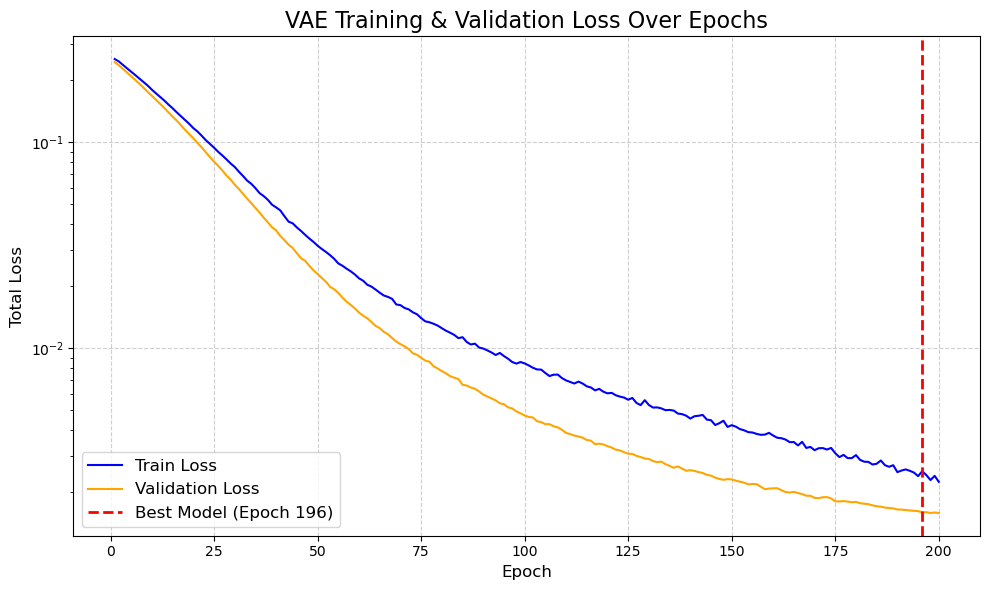

In [17]:
# Step 12：training loop with KL warmup and early stopping
best_val = float('inf')
best_epoch = 0
epochs_since_improve = 0


train_loss_history = []
val_loss_history = []


for epoch in range(1, num_epochs + 1):
    model.train()
    train_losses = []
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        recon, mu, logvar = model(batch)
        loss = vae_loss(recon, batch, mu, logvar, beta=beta)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_losses.append(loss.item())

    model.eval()
    val_losses = []
    with torch.no_grad():
        for batch in val_loader:
            batch = batch.to(device)
            recon, mu, logvar = model(batch)
            val_loss = vae_loss(recon, batch, mu, logvar, beta=beta)
            val_losses.append(val_loss.item())

    train_loss = float(np.mean(train_losses))
    val_loss = float(np.mean(val_losses))
    

    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)
  
    
    print(f'Epoch {epoch:03d}/{num_epochs} | Train: {train_loss:.4f} | Val: {val_loss:.4f} | Beta: {beta:.2f}')

    if val_loss < best_val - 1e-4:
        best_val = val_loss
        best_epoch = epoch
        torch.save(model.state_dict(), best_state_path)
        epochs_since_improve = 0
        print(f'  -> new best model save as {best_state_path}')
    else:
        epochs_since_improve += 1
        if epochs_since_improve >= patience:
            print(f'early stop best epoch {best_epoch:03d}，Val Loss {best_val:.4f}')
            break

    if epoch <= warmup_epochs:
        beta = min(beta_max, beta + beta_increment)


print("\nTraining complete. Plotting losses...")

plt.figure(figsize=(10, 6))

plt.plot(range(1, len(train_loss_history) + 1), train_loss_history, label='Train Loss', color='blue')

plt.plot(range(1, len(val_loss_history) + 1), val_loss_history, label='Validation Loss', color='orange')


if best_epoch > 0:
    plt.axvline(x=best_epoch, color='red', linestyle='--', linewidth=2, label=f'Best Model (Epoch {best_epoch})')

plt.title('VAE Training & Validation Loss Over Epochs', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Total Loss', fontsize=12)

plt.yscale('log')
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

plt.savefig('vae_loss_curve.png', dpi=150)
plt.show()

In [78]:
# Step 13：load best model and extract latent representations
model.load_state_dict(torch.load(best_state_path, map_location=device))
model.eval()

inference_batch_size = batch_size 
full_loader = DataLoader(dataset_log1p, batch_size=inference_batch_size, shuffle=False)
latents = []
with torch.no_grad():
    for batch in full_loader:
        batch = batch.to(device)
        mu, _ = model.encode(batch)
        latents.append(mu.cpu().numpy())

latent_array = np.vstack(latents)
print('latent shape:', latent_array.shape)

latent_df = pd.DataFrame(latent_array, index=cell_names[: latent_array.shape[0]])
latent_df.to_csv('vae_latent_new1.csv')
np.save('vae_latent_new1.npy', latent_array)
print('saved vae_latent_new1.csv and vae_latent_new1.npy')


latent shape: (307, 16)
saved vae_latent_new1.csv and vae_latent_new1.npy
